# ADA EndSem P1

- Sampad Kumar Kar
- MCS202215

# 0. Imports

In [22]:
import os, sys
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# others
from scipy.interpolate import griddata


In [3]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading

In [4]:
data_dir_path = os.path.join('data')

# read BMTC.parquet.gzip
df_bmtc = pd.read_parquet(os.path.join(data_dir_path, 'BMTC.parquet.gzip'), engine='pyarrow')

df_GT = pd.read_csv(os.path.join(data_dir_path, 'GroundTruth.csv'), index_col=0)

df_input = pd.read_csv(os.path.join(data_dir_path, 'Input.csv'), index_col=0)

In [5]:
df_bmtc.head()

,BusID,Latitude,Longitude,Speed,Timestamp
0,150212121,13.074558,77.445549,0.0,2019-08-01 07:00:02
1,150212121,13.074558,77.445549,0.0,2019-08-01 07:00:12
2,150212121,13.074558,77.445549,0.0,2019-08-01 07:00:22
3,150212121,13.074558,77.445549,0.0,2019-08-01 07:00:32
4,150212121,13.074558,77.445549,0.0,2019-08-01 07:00:42


In [6]:
df_bmtc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6014946 entries, 0 to 6014945
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   BusID      int64         
 1   Latitude   float64       
 2   Longitude  float64       
 3   Speed      float64       
 4   Timestamp  datetime64[us]
dtypes: datetime64[us](1), float64(3), int64(1)
memory usage: 229.5 MB


In [7]:
df_input.head()

,Source_Lat,Source_Long,Dest_Lat,Dest_Long
0,12.941644,77.557335,12.942002,77.551605
1,12.845487,77.662079,12.845881,77.667892
2,12.973492,77.622871,12.957303,77.621246
3,12.819298,77.688995,12.814241,77.692986
4,12.973240,77.615402,13.016170,77.627800


In [8]:
df_GT.head()

,TT
0,2.833333
1,1.500000
2,21.250000
3,2.000000
4,35.733333


# 2. EDA and Preprocessing

In [9]:
# check for null values
df_bmtc.isnull().sum()

BusID        0
Latitude     0
Longitude    0
Speed        0
Timestamp    0
dtype: int64

In [10]:
# print the columns
df_bmtc.columns

Index(['BusID', 'Latitude', 'Longitude', 'Speed', 'Timestamp'], dtype='object')

In [11]:
# group by 'BusID'
busid_group = df_bmtc.groupby('BusID')

# get the number of unique 'BusID'
print('Number of unique BusID: ', len(busid_group))

Number of unique BusID:  1942


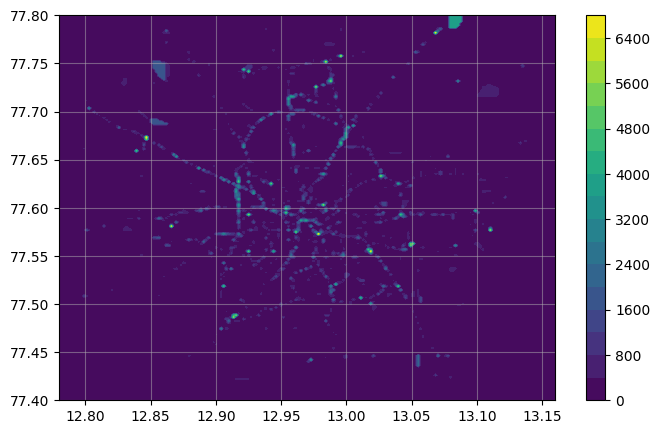

In [12]:
# create a density plot, showing the distribution of buses w.r.t. coordinates
df = df_bmtc.copy()
df = df.round({'Latitude': 3,'Longitude': 3})
data = df.groupby(['Latitude','Longitude'], as_index=False).size()
data = data[data['size']<7000]  # change this value to remove lesser outliers
grid_x, grid_y = np.mgrid[12.78:13.16:200j, 77.40:77.80:200j]
grid_z = griddata(data[['Latitude','Longitude']], data['size'], (grid_x, grid_y), method='nearest')
plt.figure(figsize=(8,5))
plt.contourf(grid_x, grid_y, grid_z, 20)
plt.colorbar()
plt.grid(True, alpha= 0.5)

## 2.1 Feature Engineering

We define a helper function to calculate the distance between two coordinates. We use the **Haversine Formula** to determine the great-circle distance between two points on a sphere given their longitudes and latitudes. This will be used to calculate the distance between the pickup and dropoff locations. 

In [13]:
# this calculates the great circle distance between two points on the earth (specified in decimal degrees)
def calulcate_distance(row):
    # convert to randians
    lon1 = row['Source_Long']
    lat1 = row['Source_Lat']
    lon2 = row['Dest_Long']
    lat2 = row['Dest_Lat']

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # calculate the angle
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # radius of earth in kilometers
    r = 6371

    # return the distance
    return c * r

In [14]:
# we combine the input and ground truth dataframes
data = pd.concat([df_input, df_GT], axis=1)

# drop duplicate rows
data.drop_duplicates(inplace=True)

# drop rows with null values
data.dropna(inplace=True)

In [15]:
data.head()

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,TT
0,12.941644,77.557335,12.942002,77.551605,2.833333
1,12.845487,77.662079,12.845881,77.667892,1.500000
2,12.973492,77.622871,12.957303,77.621246,21.250000
3,12.819298,77.688995,12.814241,77.692986,2.000000
4,12.973240,77.615402,13.016170,77.627800,35.733333


In [16]:
data.columns

Index(['Source_Lat', 'Source_Long', 'Dest_Lat', 'Dest_Long', 'TT'], dtype='object')

Now, we add a new column named `distance`, which stores the harvesine distance between source and destination.

In [17]:
# add distance column
data['Distance'] = data.apply(calulcate_distance, axis=1)
data.head()

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,TT,Distance
0,12.941644,77.557335,12.942002,77.551605,2.833333,34.039394
1,12.845487,77.662079,12.845881,77.667892,1.500000,35.687729
2,12.973492,77.622871,12.957303,77.621246,21.250000,103.580327
3,12.819298,77.688995,12.814241,77.692986,2.000000,40.556459
4,12.973240,77.615402,13.016170,77.627800,35.733333,282.785218


We finally split the dataframe into features and target. We use `Source_Lat`, `Source_Long`, `Destination_Lat`, `Destination_Long`, `distance` as features and `TT` as target.

In [18]:
# we split the data into features and target
X = data.drop('TT', axis=1)
y = data['TT']

## 2.2 Train-Test Split

We create a 80-20 split of the data into training and testing sets. We use the `train_test_split` function from `sklearn.model_selection` to do this.

In [19]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shape of X_train, X_test, y_train, y_test
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (964, 5)
Shape of X_test:  (241, 5)
Shape of y_train:  (964,)
Shape of y_test:  (241,)


# 3. Model Fitting and Evaluation

## 3.1 Linear Regression

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [23]:
# make predictions on the test set
y_pred = lin_reg.predict(X_test)

# calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of Linear Regression model is: ', mae)

# calculate the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 Score of Linear Regression model is: ', r2)

Mean Absolute Error of Linear Regression model is:  10.023669427122304
R2 Score of Linear Regression model is:  0.6771106090723453


## 3.2 Random Forest Regression

In [24]:
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=2)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200)

In [26]:
# make predictions on the test set
y_pred = rf_reg.predict(X_test)

# calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of Random Forest Regressor model is: ', mae)

# calculate the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 Score of Random Forest Regressor model is: ', r2)

Mean Absolute Error of Random Forest Regressor model is:  5.7821443809385675
R2 Score of Random Forest Regressor model is:  0.857367384971856


We now check the predicted output of the Random Forest Regressor against some points from the test set.

In [29]:
# compare the actual and predicted values for the first 10 rows
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_pred.head(10)

,Actual,Predicted
101,1.983333,5.413800
946,43.316667,58.153429
306,35.283333,18.388118
109,10.550000,9.504270
1061,59.783333,58.627636
1176,59.816667,58.603553
630,10.150000,13.444437
49,5.966667,14.834855
479,4.150000,9.437553
924,59.933333,58.833453


We can observe that the predicted output is very close to the actual output, which is indicative of a good predictive models.

# 4. Conclusion

As we can observe, **Random Forest Regression** seems to perform better than **Linear Regression**.
- It obtains a lower *mean absolute error* of $5.78$ against $10.02$ of Linear Regression.
- It obtains a higher *R-squared* value of $0.86$ against $0.68$ of Linear Regression.

Since this model manages to explain almost $86\%$ of the variance in the data, we can conclude that it is a good fit for the data.